In [6]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random

In [30]:
def get_sample(n = 1000, m = 5):
    X = []
    Y = []
    for i in range(n):
        y = random.randint(0, m - 1)
        x = np.random.uniform(y, y + 2)
        X.append(x)
        Y.append(y)
    return np.array(X).reshape(-1, 1), np.array(Y)

In [31]:
X, y = get_sample(1000)

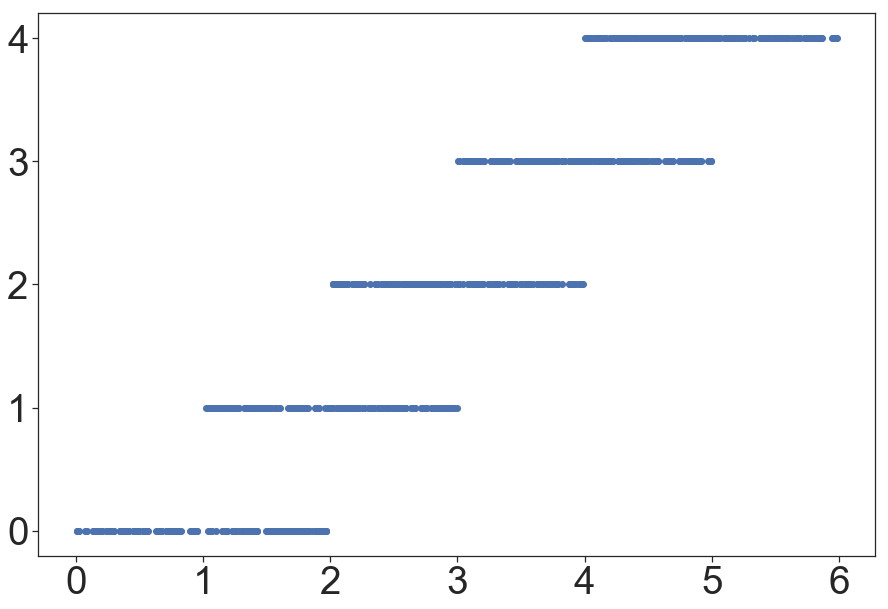

In [32]:
plt.scatter(X, y)

In [79]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math


def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(model.n_classes_*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - (model.n_classes_ - 1)/(model.n_classes_*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

def get_mutual_information(X, y, n_estimators = 300, max_samples = .32, depth = 30):
    cond_entropy = cef_estimate(X, y, n_estimators = n_estimators, max_samples = max_samples, depth = depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy
X, y = get_sample(30000, 5)
get_mutual_information(X, y)



0.9626301024966701

In [ ]:
mixed.Mixed_KSG(X, y.reshape(-1, 1))

In [69]:
from tqdm import tqdm_notebook
import sys
sys.path.insert(0, "./code")
import entropy_estimators as ee
import mixed

def mutual_information_v_n(m = 2):
    sample_sizes = [i*50 for i in range(1, 51)]

    cef = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(sample_sizes):
        X, y = get_sample(n, m)
        h_y = get_entropy(y)
        kraskov.append(ee.micd(X, y.reshape(-1, 1)))
        cef.append(get_mutual_information(X, y)/h_y)
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1))/h_y)
    return sample_sizes, cef, kraskov, mixed_ksg

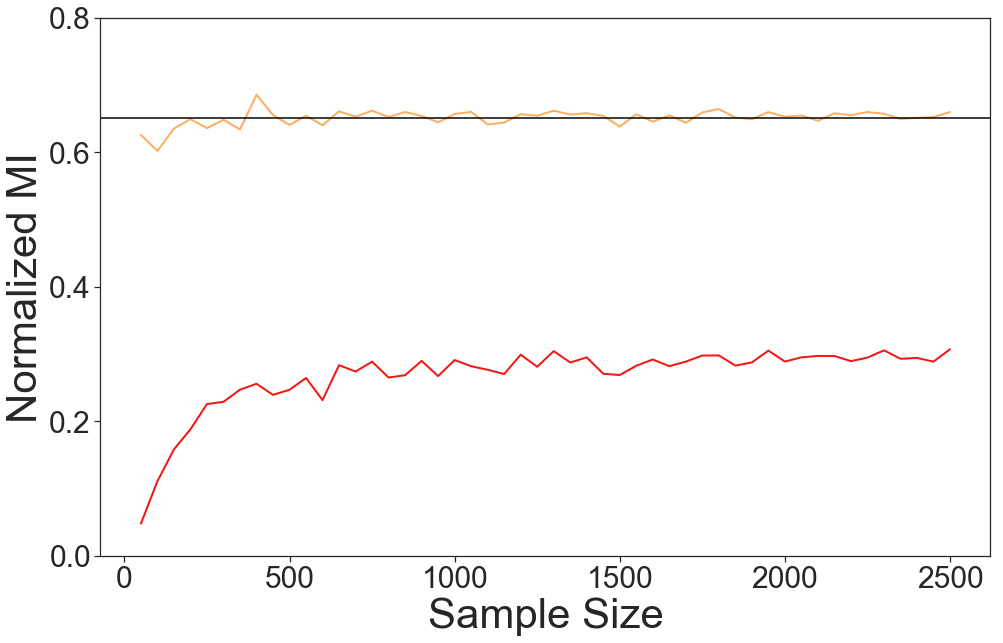

In [82]:
#sample_sizes, cef, kraskov, mixed_ksg = mutual_information_v_n(5)
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, kraskov, label = "KSG", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, mixed_ksg, label = "Mixed KSG", linewidth = 2, color = "#fdae61")


line_true = plt.axhline(y=.65,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Normalized MI")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
#plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("mi_mixed_m_5.pdf")
plt.show()

In [50]:
print(cef)

[0.973163418758083, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [74]:
X, y = get_sample(100000,  m = 2)

In [75]:
get_entropy(y)

0.6931392603390353